
# **1.3 Preprocessing function for U-Net Segmentation Model**

FIRST PART: **LOCAL**  
data on local/ extern SSD  

SECOND PART: **SC INFRASTRUCTURE**   
data in personal workspace


**!!! ATTENTION !!!**    
Select right Kernel/Environment with PyTorch installed: `pytorch_env_pyth311`

## 1. Preparations
### 1.1 Install required packages

In [2]:
# check current python version and environment
!python --version
!where python 

Python 3.11.11
c:\Users\simon\anaconda3\envs\pytorch_env_pyth311\python.exe
C:\Users\simon\AppData\Local\Microsoft\WindowsApps\python.exe


In [3]:
# import required packages
import json
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# !pip install segmentation-models-pytorch

In [5]:
# import segmentation models module
import segmentation_models_pytorch as smp

c:\Users\simon\anaconda3\envs\pytorch_env_pyth311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Load data

In [6]:
# Data directories on external SSD   # -------------------->> ADJUSTABLE
# npy patches
patches_raw_dir = r'D:\MoSE\preprocessing\patches_raw'
# masks
masks_dir = r'D:\MoSE\preprocessing\masks'
# JSON class codes
codes_dir = r'D:\MoSE\preprocessing\codes'
# Shapefile class labels
labels_dir = r'C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\shapefiles'

In [7]:
# Class codes
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Totholz': 1, 'Wurzelstock': 2, 'Sand_Schlammbank': 3, 'Schotterbank': 4}


4

## 2. Chosen segmentation model

In [8]:
model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
)

## 3. Configure data preprocessing

Configure data preprocessing function (preprocess_input) for a specific model (encoder):

`from segmentation_models_pytorch.encoders import get_preprocessing_fn`

`preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')`

Encoder = the part of the neural network that extracts features from the input data (in this case the pre-trained model “resnet” on ImageNet)     
Pretraining = encoder already trained on a large dataset (e.g. ImageNet) > can recognize useful features

Why data preprocessing is necessary:
- During the training of the pre-trained weights (e.g. on ImageNet), specific pre-processing was applied to the images, e.g. normalization, resizing or color space conversion.
- To achieve the best possible performance with the pre-trained weights, the input data should be preprocessed in the same way as it was done during the pre-training.

What `get_preprocessing_fn` does:
This function returns a preprocessing function (preprocess_input) that performs the exact same transformations that were applied to the ImageNet dataset during pretraining.

In [9]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet') # load specific (suitable to chosen model) preprocessing function

In [10]:
# create output directory for preprocessed patches
output_pre_patches_dir = r'D:\MoSE\preprocessing\patches_pre'

if not os.path.exists(output_pre_patches_dir):
    os.makedirs(output_pre_patches_dir)

In [11]:
patches_list = [f for f in os.listdir(patches_raw_dir)]  # list of all patches
# patches_list

if 'A08_patch_23.npy' in patches_list:
    print("File does exist!")

File does exist!


In [12]:
# PREPROCESSING LOOP

for idx, patch_name in enumerate(patches_list): # iterate over all patches
    patch_path = os.path.join(patches_raw_dir, patch_name)  # path to specific patch
    patch = np.load(patch_path, allow_pickle= True)  # load npy file as dictionary object (allow pickle = True)
    image_data = patch.item().get('image')   # extract image key from dictionary

    # print(f"Processing patch {idx + 1}/{len(patches_list)}: {patch_name}")
    # print(image_data.shape)

    # check if image has the right shape: [height, width, color channels]
    if image_data.shape[0] in [1, 3]:  # shape is: [C, H, W]
        image_data = image_data.transpose(1, 2, 0)  # [H, W, C]
    # print(image_data.shape)

    # use the preprocessing function
    preprocessed_image_data = preprocess_input(image_data)

    # transpose back to [C, H, W]
    preprocessed_image_data = preprocessed_image_data.transpose(2, 0, 1)

    # save preprocessed patch
    output_path = os.path.join(output_pre_patches_dir, patch_name)
    np.savez_compressed(output_path, preprocessed_image_data)

    # display progress
    if idx % 100 == 0:
        print(f"Processed {idx}/{len(patches_list)} patches")

Processed 0/3837 patches
Processed 100/3837 patches
Processed 200/3837 patches
Processed 300/3837 patches
Processed 400/3837 patches
Processed 500/3837 patches
Processed 600/3837 patches
Processed 700/3837 patches
Processed 800/3837 patches
Processed 900/3837 patches
Processed 1000/3837 patches
Processed 1100/3837 patches
Processed 1200/3837 patches
Processed 1300/3837 patches
Processed 1400/3837 patches
Processed 1500/3837 patches
Processed 1600/3837 patches
Processed 1700/3837 patches
Processed 1800/3837 patches
Processed 1900/3837 patches
Processed 2000/3837 patches
Processed 2100/3837 patches
Processed 2200/3837 patches
Processed 2300/3837 patches
Processed 2400/3837 patches
Processed 2500/3837 patches
Processed 2600/3837 patches
Processed 2700/3837 patches
Processed 2800/3837 patches
Processed 2900/3837 patches
Processed 3000/3837 patches
Processed 3100/3837 patches
Processed 3200/3837 patches
Processed 3300/3837 patches
Processed 3400/3837 patches
Processed 3500/3837 patches
Proc

## 4. Unzip .npz-patches

**CHANGE TO SC INFRASTRUCTURE**

In [ ]:
# new paths to workspace data


## 5. Check if preprocessing worked

In [14]:
SECTION = "A01"
TEST_PATCH_ID = 100 # -------------------->> ADJUSTABLE

In [ ]:
# preprocessed patch path
preprocessed_patch_path = output_pre_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (NO DICTIONARY ANYMORE)
preprocessed_patch = np.load(preprocessed_patch_path)

AttributeError: 'NpzFile' object has no attribute 'transpose'

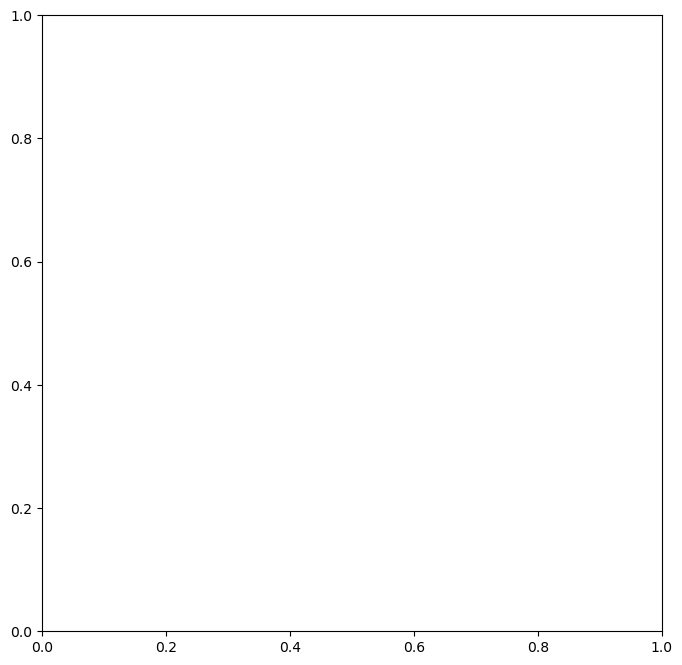

In [18]:
# plot the preprocessed image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(preprocessed_patch.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("Preprocessed NumpyArray Patch")
plt.show()